This section will borrow heavily from the NCEAS/Arctic Data Center [workshop material](https://learning.nceas.ucsb.edu/2022-09-arctic/sections/10-geopandas.html)!

Let's go exploring on the Arctic Data Center's [catalog](https://arcticdata.io/catalog/data)! I searched for `.tif` files and found a dataset from Berner, L.T., P. Jantz, K.D. Tape, and S.J. Goetz. 2018. Tundra plant above-ground biomass and shrub dominance mapped across the North Slope of Alaska. Environmental Research Letters. 13(3):035002. https://doi.org/10.1088/1748-9326/aaaa9a

In [ ]:

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import urllib

In [ ]:
# pip install rasterio
import rasterio

# Part 1: Raster data

Below, we are going to pull data directly off of the Arctic Data Center's repository. The URL is for the data entry, which is the first argument in  `urlretrieve`, and the second argument is the specific file to be downloaded

In [46]:
url = 'https://cn.dataone.org/cn/v2/resolve/urn:uuid:8233336b-0b1c-4809-b01e-4786f26db63a'

msg = urllib.request.urlretrieve(url, "shrub_dominance_of_agb_p50.tif")

Let's take a look at the `.tif` we just downloaded

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 35405, 'height': 14890, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(30.0, 0.0, -540475.274307,
       0.0, -30.0, 2380628.0574), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


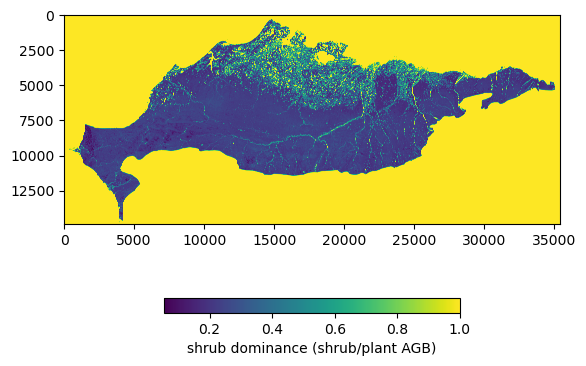

In [67]:
fig, ax = plt.subplots()
with rasterio.open("shrub_dominance_of_agb_p50.tif", masked=True) as shrub_dom:
    # read in raster (1st band)
    shrub_arr = shrub_dom.read(1)
    # shrub_arr = ma.masked_where(shrub_arr == shrub_dom.nodata, shrub_arr)
    shrub_arr = shrub_arr/255.0
    shrub_meta = shrub_dom.profile

im0 = ax.imshow(shrub_arr)
cb = fig.colorbar(im0, ax=ax, label="shrub dominance (shrub/plant AGB)",  orientation='horizontal', fraction=0.04, pad=0.2)
print(shrub_meta)

# Part 2: vector data

<Axes: >

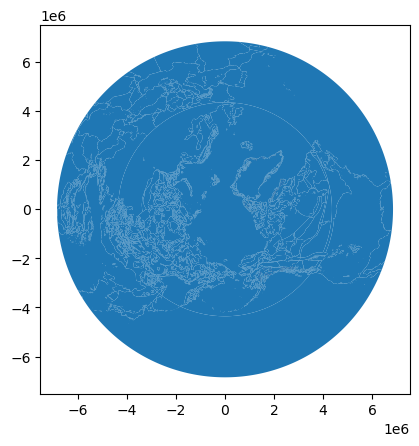

In [12]:
permafrost = gpd.read_file(os.path.join(os.path.dirname(os.getcwd()),"./arctic-data/permaice.shp"))

permafrost.plot()

<Axes: >

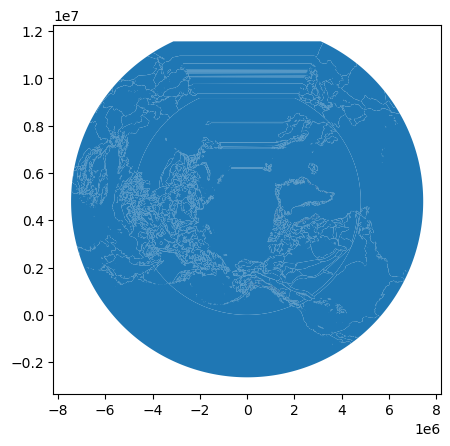

In [13]:
permafrost = permafrost.to_crs("EPSG:3338")

permafrost.plot()

In [34]:
with rasterio.open("shrub_dominance_of_agb_p97_5.tif", masked=True) as shrub_dom:
    # bounds=[shrub_dom.bounds[0], shrub_dom.bounds[1], shrub_dom.bounds[2], shrub_dom.bounds[3]]
    # print(bounds)
    bbox = box(shrub_dom.bounds[0], shrub_dom.bounds[1], shrub_dom.bounds[2], shrub_dom.bounds[3])
    coord_box_df = gpd.GeoDataFrame(crs = 'EPSG:3338',geometry = [bbox])

# permafrost_clip = gpd.sjoin(permafrost,
#                       coord_box_df,
#                       how='inner',
#                       predicate='intersects')

permafrost_clip = permafrost.clip(coord_box_df)

In [38]:
permafrost_clip.columns

Index(['NUM_CODE', 'COMBO', 'RELICT', 'EXTENT', 'CONTENT', 'LANDFORM',
       'geometry'],
      dtype='object')

"combo" is the three letter combination of permafrost extent, ice content, and overburden (soil) thickness. Read the user manual [here](https://nsidc.org/sites/default/files/ggd318-v002-userguide.pdf)

<Axes: >

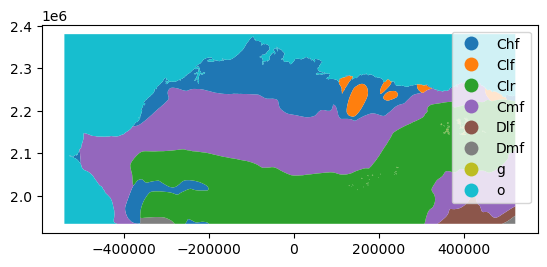

In [39]:
permafrost_clip.plot(column="COMBO", legend=True, alpha=0.5)

# Part 3: together!

`rasterio.plot.show(src)` can plot raster data. But rasters are just grids (or arrays) of numbers. If you tell `plt.imshow()` the extent (boundaries) of the image (the data array), you can transform your raster data however you want, and you can plot it with vector data as well. 

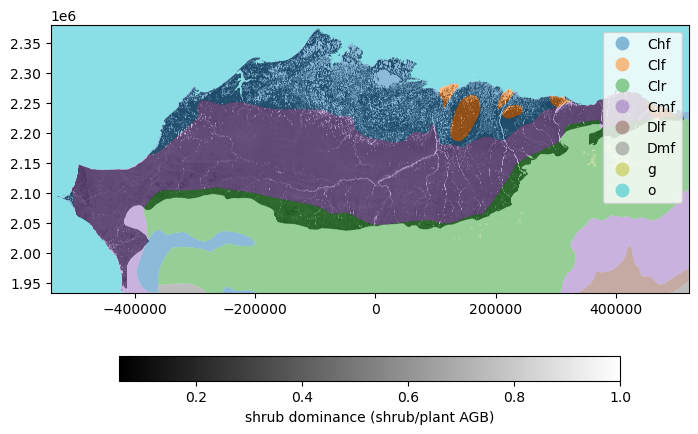

In [71]:
fig, ax = plt.subplots(figsize=(7, 7))
with rasterio.open("shrub_dominance_of_agb_p50.tif", masked=True) as shrub_dom:
    extent=[shrub_dom.bounds[0], shrub_dom.bounds[2], shrub_dom.bounds[1], shrub_dom.bounds[3]]
    im0 = ax.imshow(shrub_dom.read(1)/255.0,
    extent=extent,
    # vmin=0.0,
    # vmax=1.0,
    cmap="binary_r",
    zorder=0,
    )

    shape = permafrost_clip.plot(column="COMBO", legend=True, alpha=0.5, zorder=2, ax=ax)

cb = fig.colorbar(im0, ax=ax, label="shrub dominance (shrub/plant AGB)",  orientation='horizontal', fraction=0.04, pad=0.1)

fig.tight_layout()